In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


In [17]:
# Generate synthetic dataset (3 Gaussian blobs, 4 features)
X, y = make_blobs(n_samples=600, centers=3, n_features=4, cluster_std=1.2, random_state=42)

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(y.reshape(-1, 1))

# Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)


In [18]:
class SimpleNN:
    def __init__(self, input_size, hidden_layers, output_size, lr=0.01):
        self.lr = lr
        h1, h2 = hidden_layers

        # Xavier initialization
        self.W1 = np.random.randn(input_size, h1) / np.sqrt(input_size)
        self.W2 = np.random.randn(h1, h2) / np.sqrt(h1)
        self.W3 = np.random.randn(h2, output_size) / np.sqrt(h2)

    def relu(self, z, derivative=False):
        if derivative:
            return (z > 0).astype(float)
        return np.maximum(0, z)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = X @ self.W1
        self.a1 = self.relu(self.z1)

        self.z2 = self.a1 @ self.W2
        self.a2 = self.relu(self.z2)

        self.z3 = self.a2 @ self.W3
        self.out = self.softmax(self.z3)
        return self.out

    def backward(self, X, Y, y_pred):
        m = X.shape[0]
        d3 = (y_pred - Y) / m
        dW3 = self.a2.T @ d3

        d2 = (d3 @ self.W3.T) * self.relu(self.z2, derivative=True)
        dW2 = self.a1.T @ d2

        d1 = (d2 @ self.W2.T) * self.relu(self.z1, derivative=True)
        dW1 = X.T @ d1

        # Update weights
        self.W3 -= self.lr * dW3
        self.W2 -= self.lr * dW2
        self.W1 -= self.lr * dW1


In [19]:
# Network config
input_size = X_train.shape[1]
hidden_layers = (12, 8)
output_size = Y_train.shape[1]

nn = SimpleNN(input_size, hidden_layers, output_size, lr=0.01)

epochs = 120
train_losses, test_losses, train_accs, test_accs = [], [], [], []

for epoch in range(epochs):
    # Forward + Backward
    train_pred = nn.forward(X_train)
    nn.backward(X_train, Y_train, train_pred)

    # Loss (cross-entropy)
    eps = 1e-9
    train_loss = -np.mean(np.sum(Y_train * np.log(train_pred + eps), axis=1))
    train_acc = np.mean(np.argmax(train_pred, axis=1) == np.argmax(Y_train, axis=1))

    # Test
    test_pred = nn.forward(X_test)
    test_loss = -np.mean(np.sum(Y_test * np.log(test_pred + eps), axis=1))
    test_acc = np.mean(np.argmax(test_pred, axis=1) == np.argmax(Y_test, axis=1))

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d}: Train Loss={train_loss:.3f}, Acc={train_acc*100:.2f}% | Test Acc={test_acc*100:.2f}%")


Epoch 000: Train Loss=1.174, Acc=34.00% | Test Acc=31.33%
Epoch 020: Train Loss=1.067, Acc=41.56% | Test Acc=36.00%
Epoch 040: Train Loss=0.998, Acc=67.56% | Test Acc=68.67%
Epoch 060: Train Loss=0.947, Acc=85.11% | Test Acc=87.33%
Epoch 080: Train Loss=0.902, Acc=93.33% | Test Acc=94.67%
Epoch 100: Train Loss=0.858, Acc=97.33% | Test Acc=96.67%


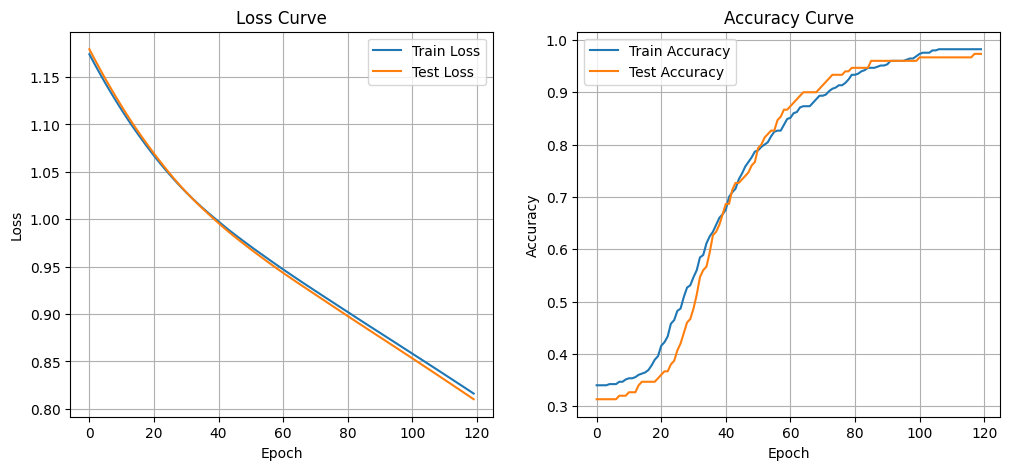

In [20]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.show()
